## Import MLatom

In [1]:
# import mlatom
import mlatom as ml 

## Optimize transition state and calculate frequency

In [2]:
# load initial transitiona state
init_ts1 = ml.data.molecule.from_xyz_string('''32

C -1.73655 0.90008 0.18271
C -1.02608 0.83877 -1.14114
C -1.01999 1.05389 1.43154
C 0.08653 1.69934 -1.47134
C 0.26098 1.54795 1.66322
C 1.08110 2.16567 -0.64431
C 1.21066 2.01363 0.75521
O -2.94833 0.64245 0.17805
H 0.18669 1.93971 -2.52895
H 1.88401 2.72026 -1.12893
H 2.13801 2.38605 1.18649
H 0.56299 1.57821 2.70960
C -0.44114 -1.66332 0.99996
H -1.65054 0.85710 2.29424
C -0.52580 -0.99222 -1.23666
H -1.78094 0.82031 -1.92593
C 0.40932 -1.20338 -0.07777
C -1.72552 -1.70133 -0.88398
H -0.15259 -1.03363 -2.25558
C -1.67904 -2.03540 0.47267
H -0.12666 -1.81645 2.02301
H -2.58230 -1.82716 -1.53354
H -2.49836 -2.46095 1.03963
C 1.75778 -1.02993 -0.06102
C 2.59624 -1.30352 1.16016
C 2.54815 -0.68554 -1.29546
H 1.93116 -0.28290 -2.09981
H 3.06091 -1.58290 -1.67294
H 3.32646 0.05119 -1.06623
H 2.00522 -1.49549 2.05720
H 3.25334 -0.44950 1.36358
H 3.24936 -2.17178 0.99084
''')

In [3]:
# choose optimal UAIQM method
uaiqm_optimal = ml.models.uaiqm(method='uaiqm_optimal', verbose=False)
uaiqm_optimal.select_optimal(
    molecule=init_ts1,
    nCPUs=1,
    time_budget='0.1s'
)

In [ ]:
# optimize geometry and get frequencies
geomopt = ml.optimize_geometry(
    model=uaiqm_optimal,
    initial_molecule=init_ts1,
    ts=True,
    program='geometric'
)
optmol_ts1 = geomopt.optimized_molecule
ml.freq(model=uaiqm_optimal, molecule=optmol_ts1)
# This might print 'WARNING: Uncertainty is too high for selected UAIQM method' which is because the error bar is too high to ensure the chemical accuracy (the calculations might/are still rather good though)

## Generate initial conditions

In [5]:
# get initial conditions
for ifreq in range(len(optmol_ts1.frequencies)):
    if optmol_ts1.frequencies[ifreq] > 0 and optmol_ts1.frequencies[ifreq] < 100:
        optmol_ts1.frequencies[ifreq] = 100

init_cond_db = ml.generate_initial_conditions(molecule=optmol_ts1,
                                            generation_method='harmonic-quantum-boltzmann',
                                            number_of_initial_conditions=1000,
                                            initial_temperature=298,
                                            use_hessian=False)
# dump forward initial conditions
init_cond_db.dump(f'TS1_incond_298.json',format='json')

# Reverse the velocities to get the backward trajectories
re_init_cond_db = init_cond_db.copy()
for mol in re_init_cond_db:
    for atom in mol:
        atom.xyz_velocities = -atom.xyz_velocities
# dump backward initial conditions
re_init_cond_db.dump(f're_TS1_incond_298.json',format='json')

## Propagate dynamics

In [ ]:
# propagate one forward trajectory
init_mol = init_cond_db[0]
dyn = ml.md(model=uaiqm_optimal,
            molecule_with_initial_conditions = init_mol,
            ensemble='NVE',
            time_step=1,
            maximum_propagation_time=500,
            )
traj = dyn.molecular_trajectory
traj.dump(filename=f'forward_temp298_mol0', format='plain_text')

# propagate backward trajectory
re_init_mol = re_init_cond_db[0]
dyn = ml.md(model=uaiqm_optimal,
            molecule_with_initial_conditions = re_init_mol,
            ensemble='NVE',
            time_step=1,
            maximum_propagation_time=500,
            )
traj = dyn.molecular_trajectory
traj.dump(filename=f'backward_temp298_mol0', format='plain_text')

## Check reactive trajectories and plot bond changes

In [7]:
# check reactive trajectories
import numpy as np
def get_bond_data(traj_xyz, bonds):
    nmol = len(traj_xyz)
    data = np.zeros((nmol, len(bonds)))
    for ii in range(nmol):
        mol = traj_xyz[ii]
        bl_list = []
        for bond in bonds:
            bl = mol.internuclear_distance(bond[0], bond[1])
            bl_list.append(bl)
        data[ii] = bl_list
    return data

def check_reactive(traj_bond_data):
    P1 = False # C2-C15 C7-C24
    P2 = False # C2-C15 C3-C13
    for ii in range(traj_bond_data.shape[0]):
        bond_data = traj_bond_data[ii]
        if bond_data[0] <= 1.6 and bond_data[1] <= 1.6:
            P2 = True
        if bond_data[0] <= 1.6 and bond_data[2] <= 1.6:
            P1 = True

    return P1, P2

def plot(traj_data, target_path):
    ax = plt.figure().add_subplot(projection='3d')
    traj_data[traj_data>=5] = np.nan 
    ax.scatter(traj_data[:,2], traj_data[:,1], traj_data[:,0], s=1)
    ax.set_xlabel('C7-C24')
    ax.set_ylabel('C3-C13')
    ax.set_zlabel('C2-C15')
    ax.axes.set_xlim3d(left=1, right=5)
    
    ax.axes.set_ylim3d(bottom=1, top=5)
    ax.axes.set_zlim3d(bottom=1, top=5)
    ax.axes.set_yticklabels(ax.axes.get_yticklabels(),
                verticalalignment='baseline',
                horizontalalignment='left')
    ax.tick_params(axis='z', which='major', pad=1)
    ax.tick_params(axis='x', which='major', pad=1)
    #ax.grid(False) # whether to set grids in the figure
    plt.tight_layout()
    plt.savefig(target_path, dpi=150)
    
def define_components(traj_bond_data):
    P6 = False # C2-C15 C7-C24 
    P7 = False # C2-C15 C3-C13
    C2_C15 = False
    C3_C13 = False
    C7_C24 = False

    for ii in range(traj_bond_data.shape[0]):

        bond_data = traj_bond_data[ii]
        if bond_data[0] <= 1.6 and bond_data[1] <= 1.6:
            P7 = True 
        if bond_data[0] <= 1.6 and bond_data[2] <= 1.6:
            P6 = True 
        if bond_data[0] <= 1.6:
            C2_C15 = True
        if bond_data[1] <= 1.6:
            C3_C13 = True 
        if bond_data[2] <= 1.6:
            C7_C24 = True

    return P6, P7, C2_C15, C3_C13, C7_C24

In [8]:
ntrajs = 1
component_vector = np.zeros((ntrajs, 5))

# Here we provide the example trajectory 'forward_p2_traj.xyz' and 'backward_p2_traj.xyz' containing P2
bonds = [(1,14),(2,12),(6,23)]
traj_forward = ml.data.molecular_database.from_xyz_file(f'forward_p2_traj.xyz')
traj_backward = ml.data.molecular_database.from_xyz_file(f'backward_p2_traj.xyz')
traj = ml.data.molecular_database()
traj_forward.molecules.reverse()
traj.molecules = traj_forward.molecules + traj_backward.molecules
bond_data = get_bond_data(traj, bonds=bonds)
P1, P2 = check_reactive(bond_data)
component_vector[0] = define_components(bond_data)
print(f'P1 in trajectory: {P1}')
print(f'P2 in trajectory: {P2}')

P1 in trajectory: False
P2 in trajectory: True


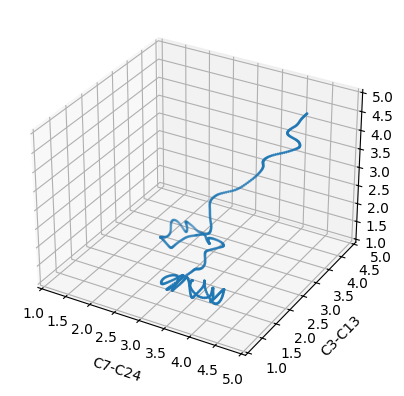

In [9]:
import matplotlib.pyplot as plt 
target_path = './traj0.png'
plot(bond_data, target_path)

## Visialization of the trajectories
Below we provide the reactive trajectories `forward_p1_traj.xyz` and `forward_p2_traj.xyz` leading to their respective product

In [10]:
import mlatom as ml

In [11]:
# load the trajectory from the file
p1_traj = ml.molecular_database.from_xyz_file(filename='forward_p1_traj.xyz')

In [12]:
# visualize it
p1_traj.view()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
# same for the other trajectory
p2_traj = ml.molecular_database.from_xyz_file(filename='backward_p2_traj.xyz')
p2_traj.view()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.